In [135]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier as XGB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [136]:
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,9))

In [137]:
churnPath = r"C:\Users\LENOVO\Desktop\Python\Projects\churn Prediction\BankChurners.csv"
churnData = pd.read_csv(churnPath)
churnData = churnData[churnData.columns[:-2]]
churnData.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [138]:
def distPlot(column, title, boxTitle = None, histTitle = None, bins=30):
    fig, axes = plt.subplots(2, 1, figsize=(12, 7))

    sns.boxplot(x=churnData[column], ax=axes[0], color='orange')
    axes[0].set_title(boxTitle)

    sns.histplot(churnData[column], bins=bins, kde=True, ax=axes[1], color='red')
    axes[1].set_title(histTitle)

    fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

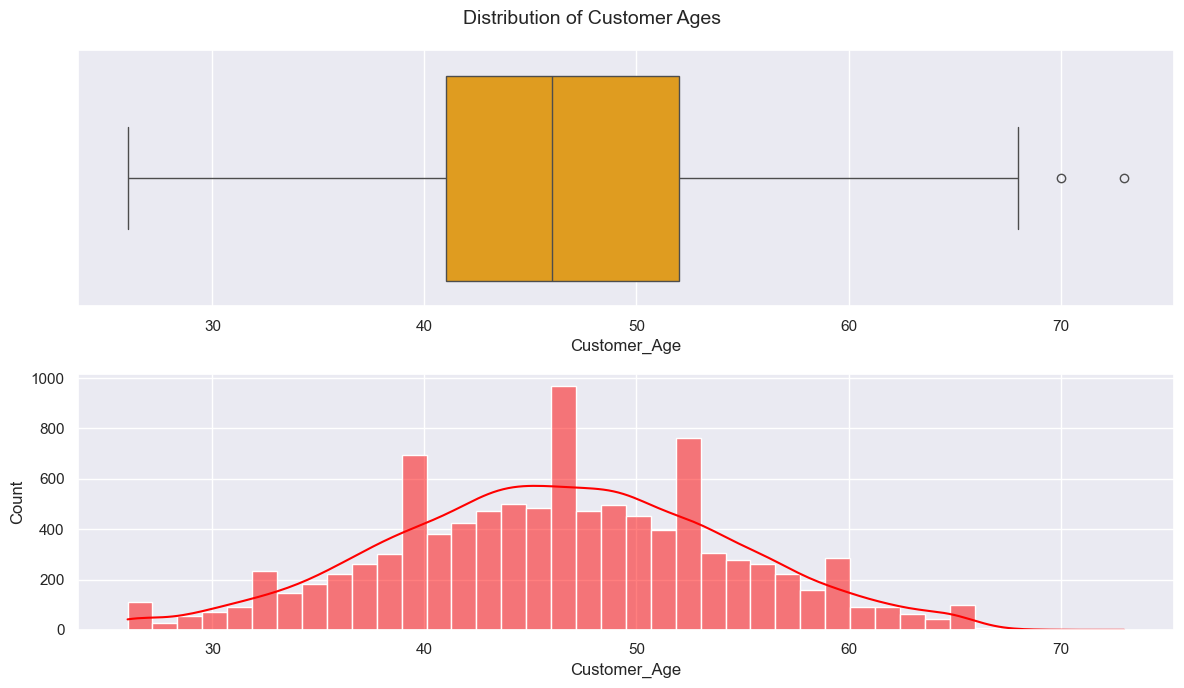

In [139]:
distPlot('Customer_Age', "Distribution of Customer Ages", bins=40)

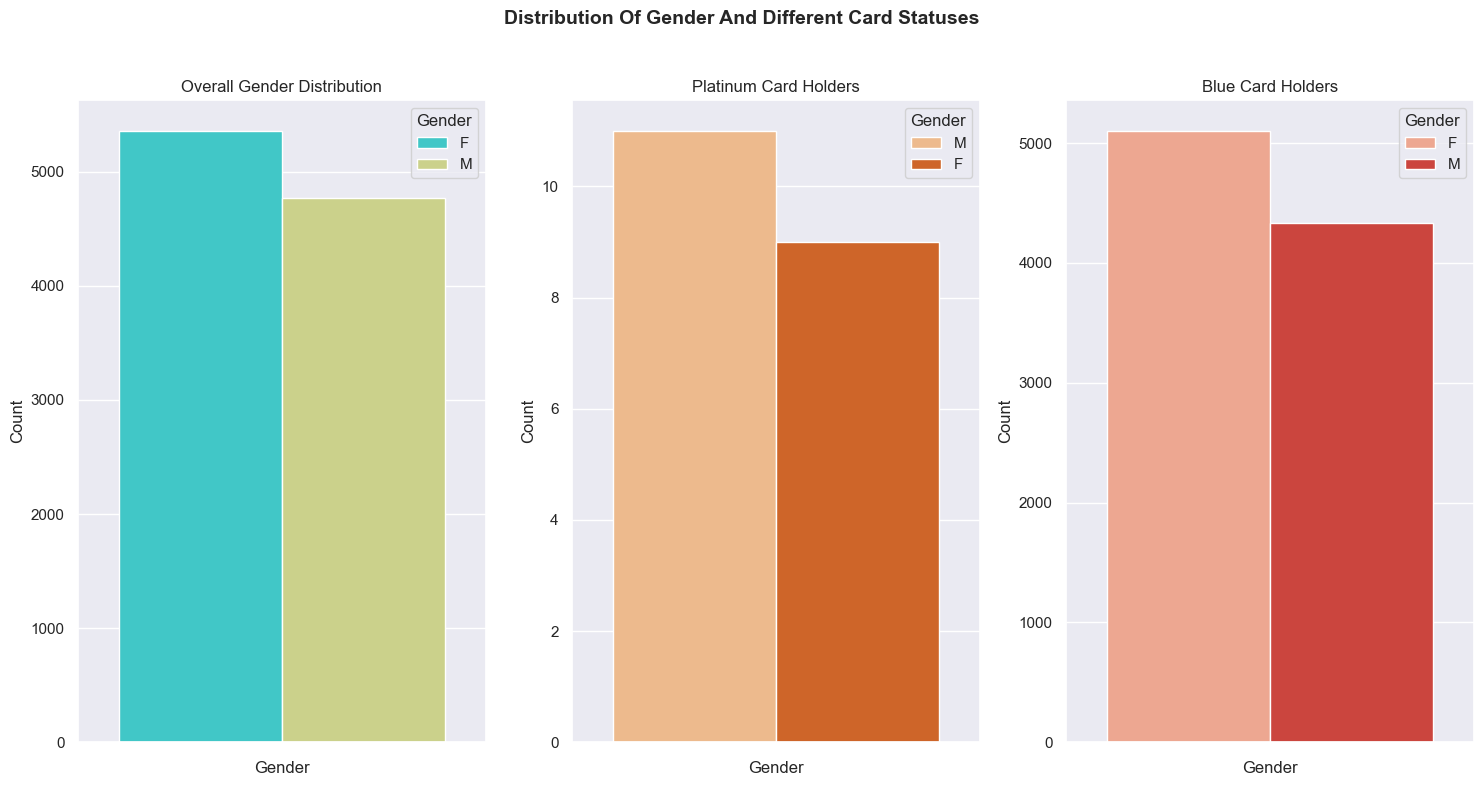

In [140]:
gender_counts = churnData['Gender'].value_counts()
platinum_counts = churnData[churnData['Card_Category'] == "Platinum"]['Gender'].value_counts()
blue_counts = churnData[churnData['Card_Category'] == "Blue"]['Gender'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

sns.barplot(hue=gender_counts.index, y=gender_counts.values, ax=axes[0], palette="rainbow")
axes[0].set_title("Overall Gender Distribution")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Gender")

sns.barplot(hue=platinum_counts.index, y=platinum_counts.values, ax=axes[1], palette="Oranges")
axes[1].set_title("Platinum Card Holders")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Gender")

sns.barplot(hue=blue_counts.index, y=blue_counts.values, ax=axes[2], palette="Reds")
axes[2].set_title("Blue Card Holders")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Gender")

plt.suptitle("Distribution Of Gender And Different Card Statuses", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])  

plt.show()

More samples of females in our dataset are compared to males, but the percentage of difference is not that significant, so we can say that genders are uniformly distributed.

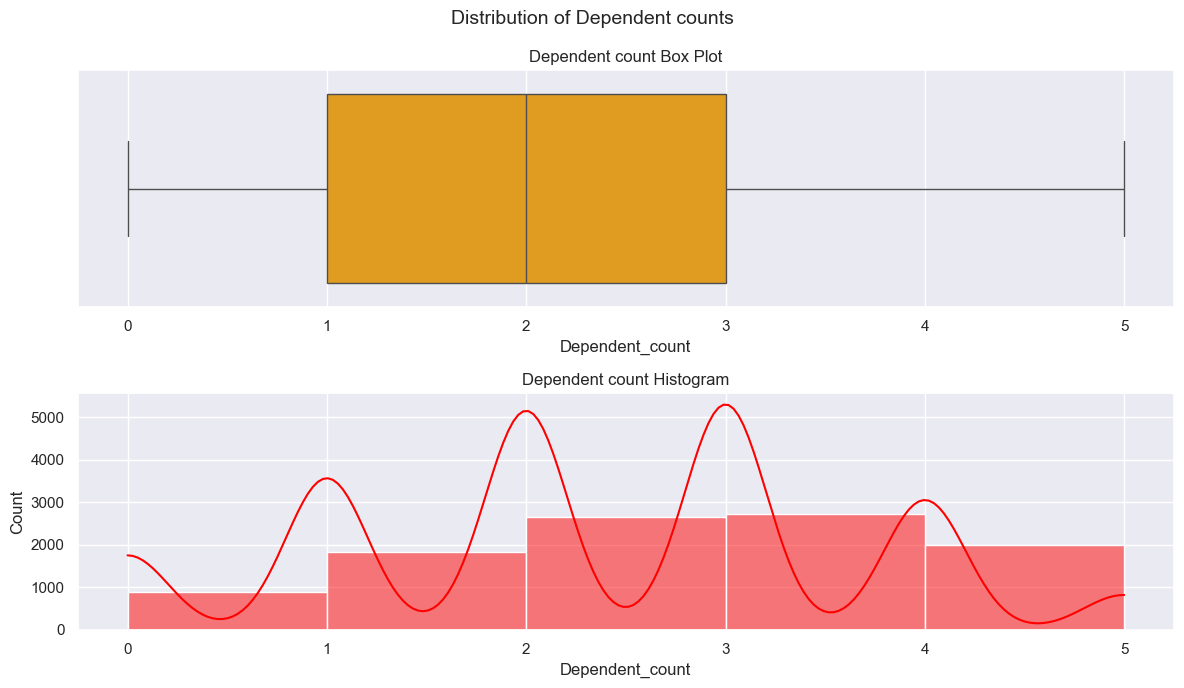

In [141]:
distPlot('Dependent_count', "Distribution of Dependent counts",'Dependent count Box Plot', 'Dependent count Histogram', bins=5)

The distribution of Dependent counts is fairly normally distributed with a slight right skew.

In [142]:
def barPlot(columnName, title, Xlabel, Ylabel):
    count = churnData[columnName].value_counts()
    percentage = (count / count.sum()) * 100  

    plt.figure(figsize=(8,6))
    bars = count.plot(kind='bar', color='skyblue')

    for bar, percentage in zip(bars.patches, percentage):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

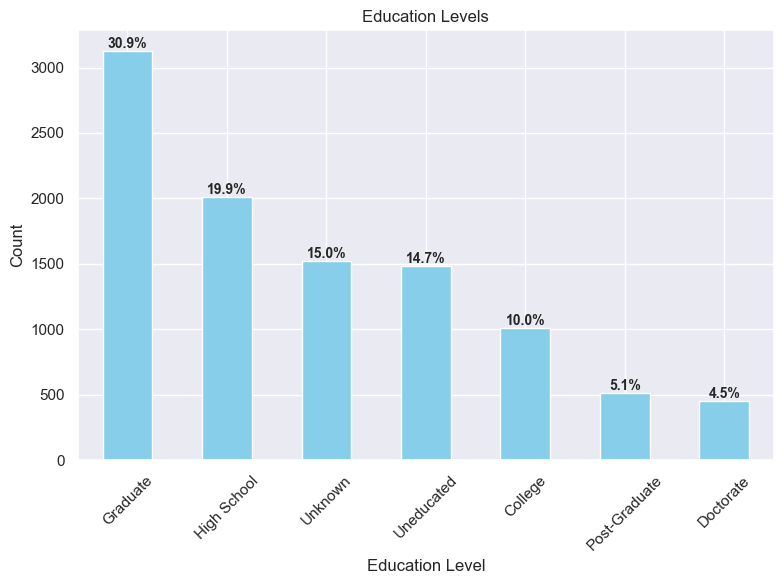

In [143]:
barPlot('Education_Level', 'Education Levels', 'Education Level', 'Count')

If most of the customers with unknown education status lack any education, we can state that more than 70% of the customers have a formal education level. About 35% have a higher level of education.

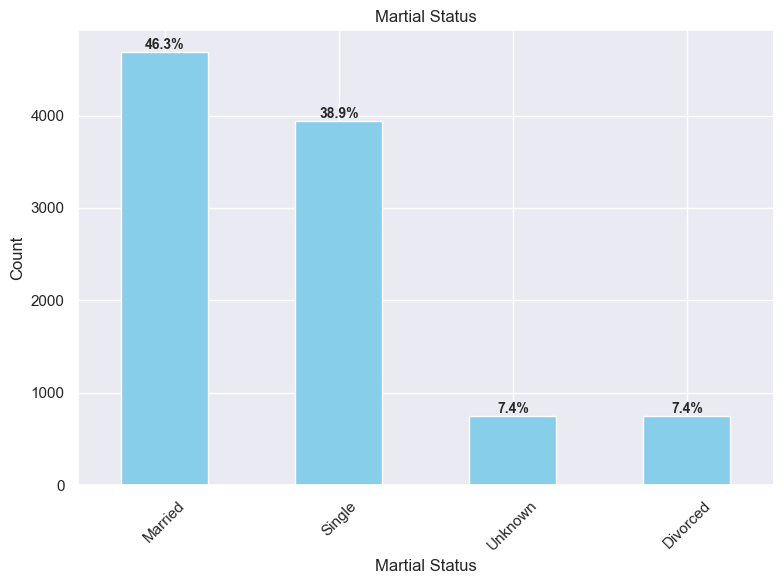

In [144]:
barPlot('Marital_Status', 'Martial Status', 'Martial Status', 'Count')

Almost half of the bank customers are married, and interestingly enough, almost the entire other half are single customers. only about 7% of the customers are divorced, which is surprising considering the worldwide divorce rate statistics.

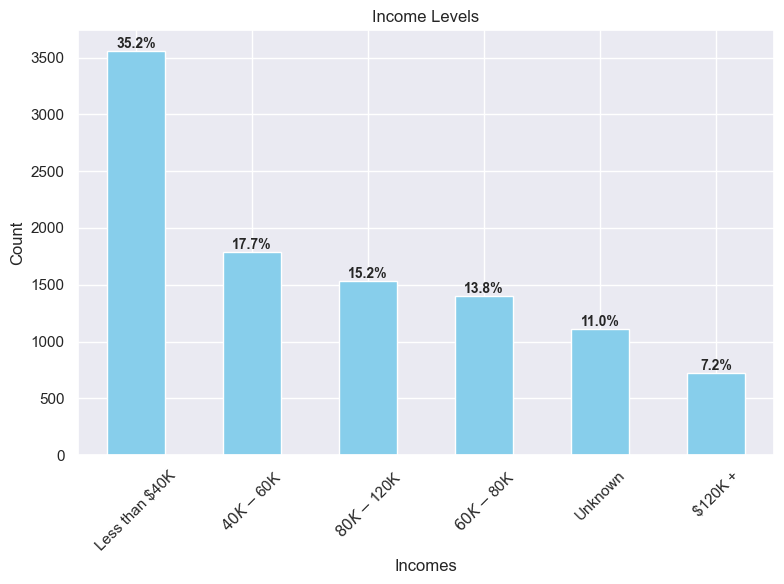

In [145]:
barPlot('Income_Category', 'Income Levels', 'Incomes', 'Count')

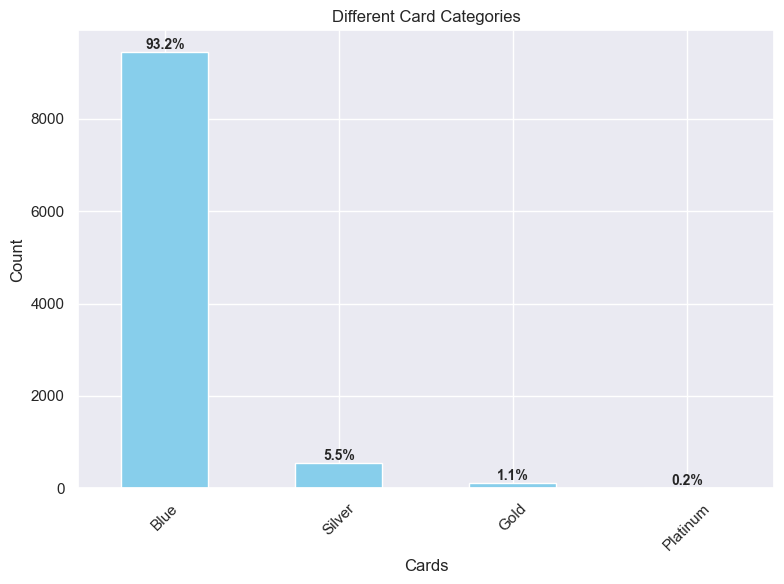

In [146]:
barPlot('Card_Category', 'Different Card Categories', 'Cards', 'Count')

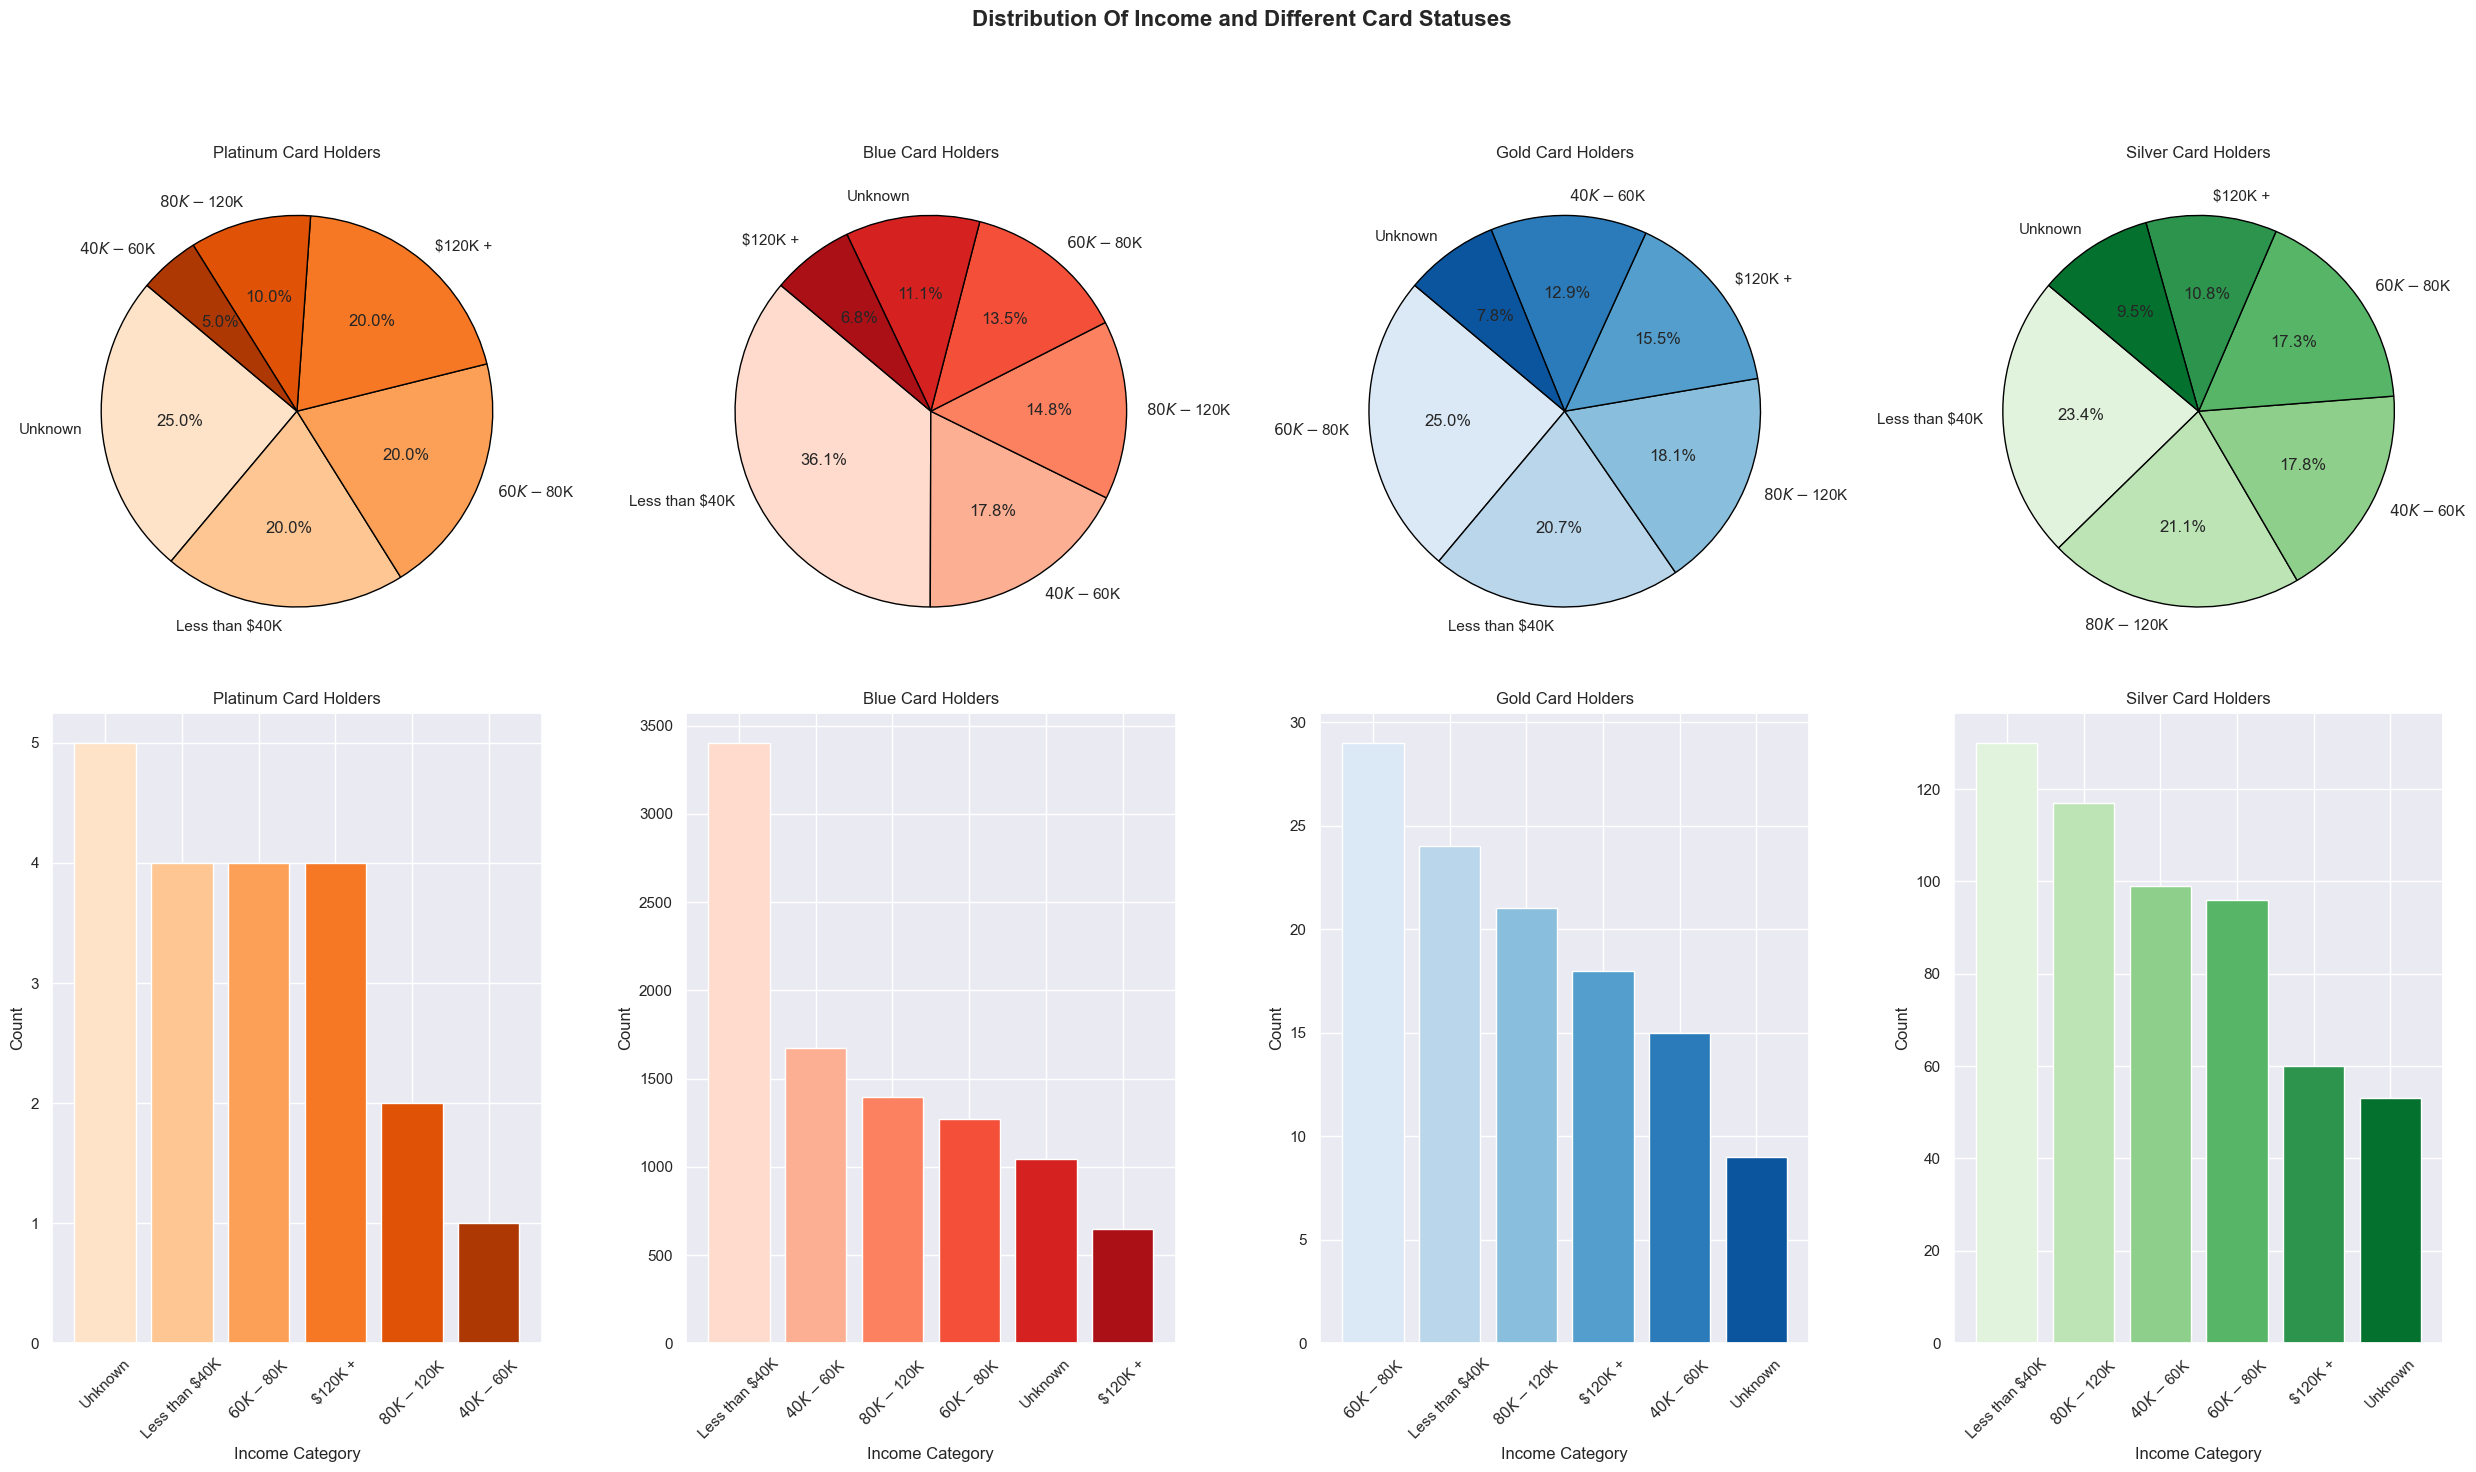

In [147]:
platinumIncome = churnData[churnData['Card_Category'] == "Platinum"]['Income_Category'].value_counts()
blueIncome = churnData[churnData['Card_Category'] == "Blue"]['Income_Category'].value_counts()
goldIncome = churnData[churnData['Card_Category'] == "Gold"]['Income_Category'].value_counts()
silverIncome = churnData[churnData['Card_Category'] == "Silver"]['Income_Category'].value_counts()

fig, axes = plt.subplots(2, 4, figsize=(25, 15))

axes[0, 0].pie(platinumIncome, labels=platinumIncome.index, autopct='%1.1f%%', colors=sns.color_palette("Oranges"), startangle=140, wedgeprops={'edgecolor': 'black'})
axes[0, 0].set_title("Platinum Card Holders")

axes[0, 1].pie(blueIncome, labels=blueIncome.index, autopct='%1.1f%%', colors=sns.color_palette("Reds"), startangle=140, wedgeprops={'edgecolor': 'black'})
axes[0, 1].set_title("Blue Card Holders")

axes[0, 2].pie(goldIncome, labels=goldIncome.index, autopct='%1.1f%%', colors=sns.color_palette("Blues"), startangle=140, wedgeprops={'edgecolor': 'black'})
axes[0, 2].set_title("Gold Card Holders")

axes[0, 3].pie(silverIncome, labels=silverIncome.index, autopct='%1.1f%%', colors=sns.color_palette("Greens"), startangle=140, wedgeprops={'edgecolor': 'black'})
axes[0, 3].set_title("Silver Card Holders")

axes[1, 0].bar(platinumIncome.index, platinumIncome.values, color=sns.color_palette("Oranges"))
axes[1, 0].set_title("Platinum Card Holders")
axes[1, 0].set_xlabel("Income Category")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(blueIncome.index, blueIncome.values, color=sns.color_palette("Reds"))
axes[1, 1].set_title("Blue Card Holders")
axes[1, 1].set_xlabel("Income Category")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=45)

axes[1, 2].bar(goldIncome.index, goldIncome.values, color=sns.color_palette("Blues"))
axes[1, 2].set_title("Gold Card Holders")
axes[1, 2].set_xlabel("Income Category")
axes[1, 2].set_ylabel("Count")
axes[1, 2].tick_params(axis='x', rotation=45)

axes[1, 3].bar(silverIncome.index, silverIncome.values, color=sns.color_palette("Greens"))
axes[1, 3].set_title("Silver Card Holders")
axes[1, 3].set_xlabel("Income Category")
axes[1, 3].set_ylabel("Count")
axes[1, 3].tick_params(axis='x', rotation=45)

plt.suptitle("Distribution Of Income and Different Card Statuses", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The greater percentage of Unknown in the Platinum Card Holders may equate to users preferring privacy, avoiding income disclosure. Though we could just assign all the unknowns to the  highest Income categories for the respective cards. For Platinum Card this be assigned to the $120k+ Income category since we can comfortably assume that they have the income to hold a Premium card.

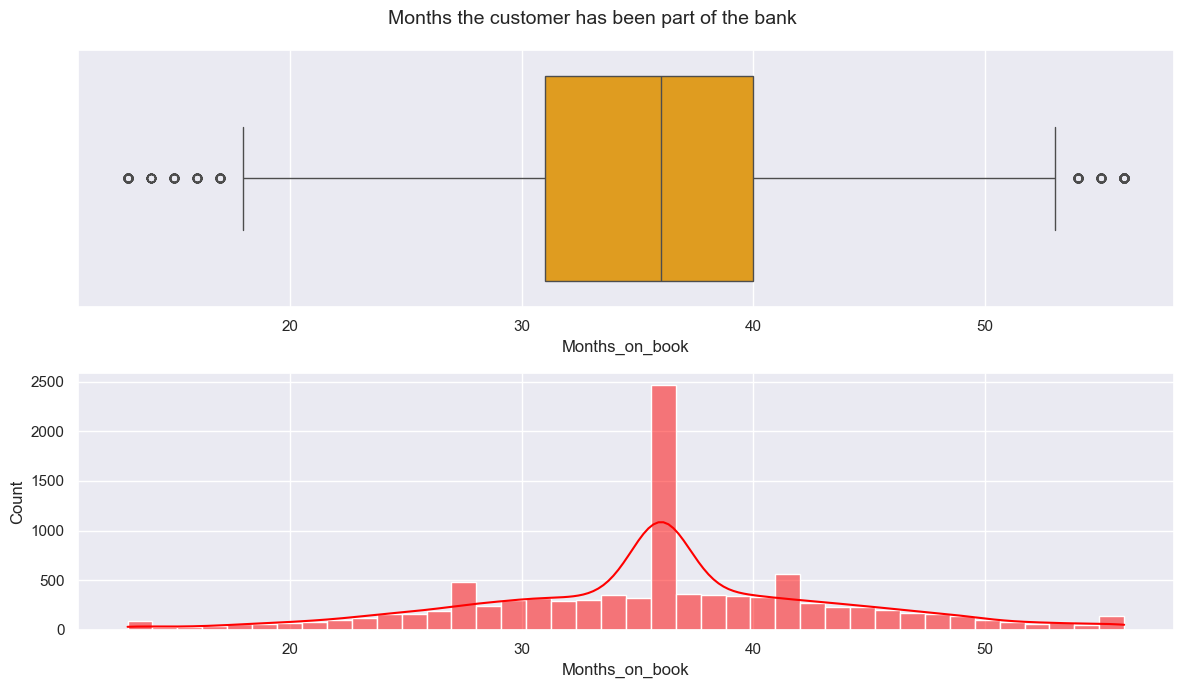

In [148]:
distPlot('Months_on_book', "Months the customer has been part of the bank", bins=40)

In [149]:
print('Kurtosis of Months on book features is : {}'.format(churnData['Months_on_book'].kurt()))

Kurtosis of Months on book features is : 0.40010012019986707


We have a low kurtosis value of 0.4 which is close to normal distribution (kurtosis = 0), meaning the feature has short tails (fewer outliers).

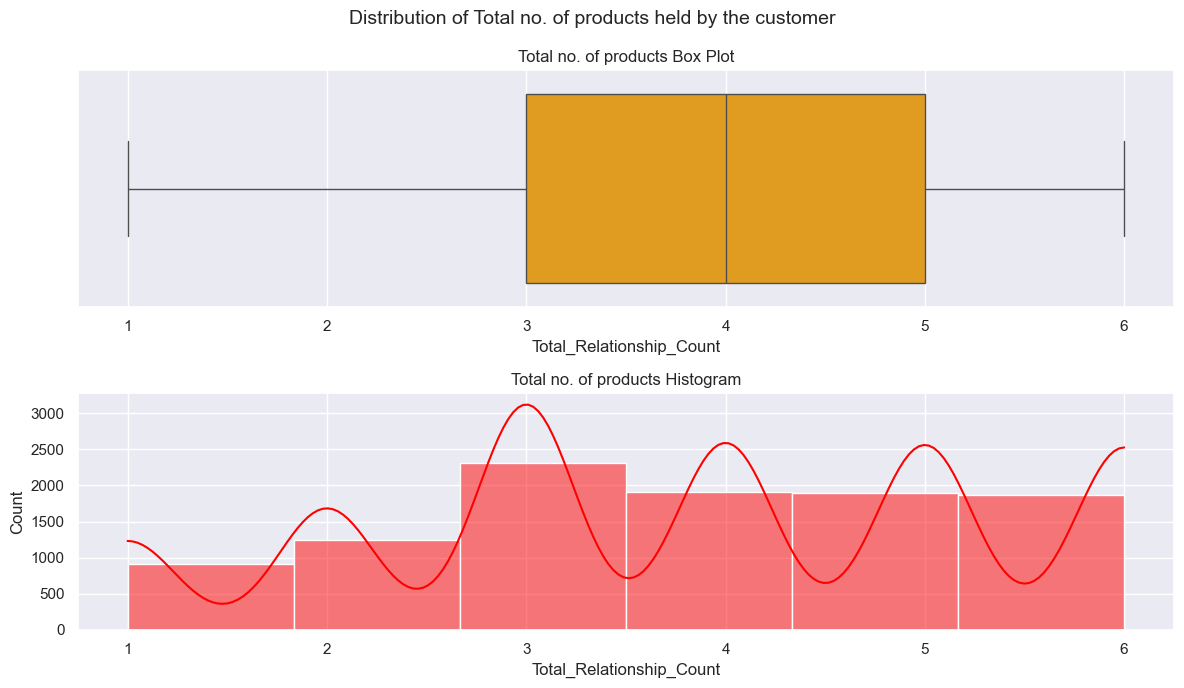

In [150]:
distPlot('Total_Relationship_Count', "Distribution of Total no. of products held by the customer", 'Total no. of products Box Plot', 'Total no. of products Histogram', bins=6)

The distribution of the total number of products held by the customer seems closer to a uniform distribution and may appear useless as a predictor for churn status.

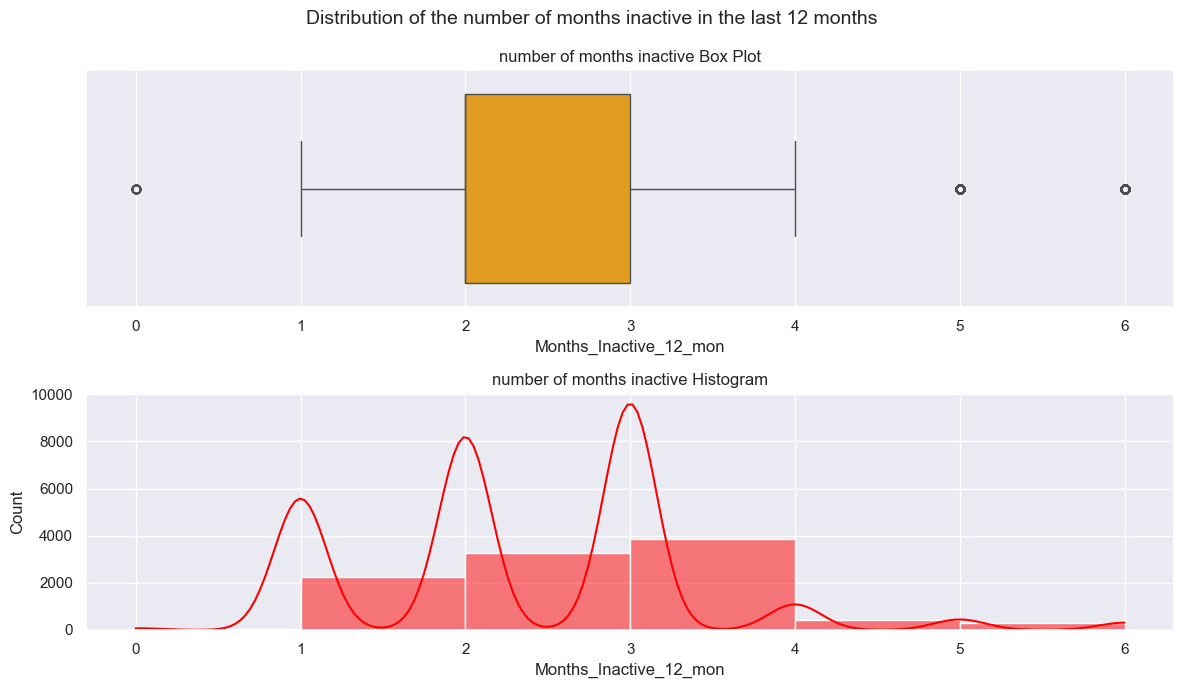

In [151]:
distPlot('Months_Inactive_12_mon', "Distribution of the number of months inactive in the last 12 months", 'number of months inactive Box Plot', 'number of months inactive Histogram', bins=6)

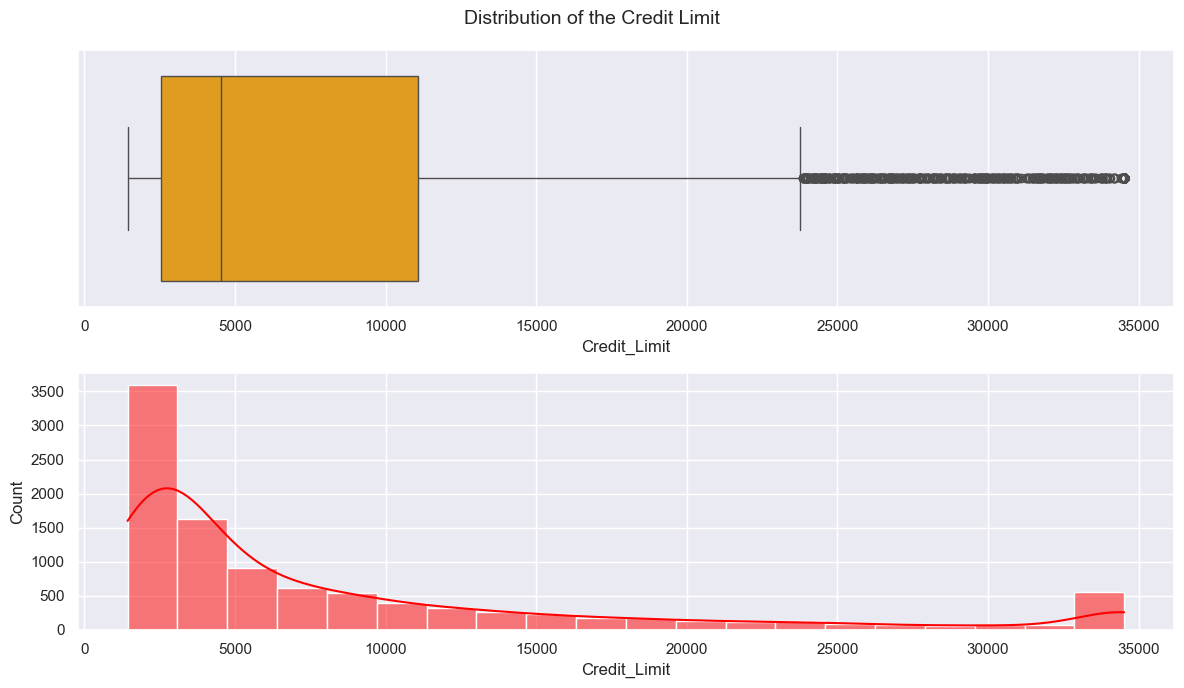

In [152]:
distPlot('Credit_Limit', "Distribution of the Credit Limit", bins=20)

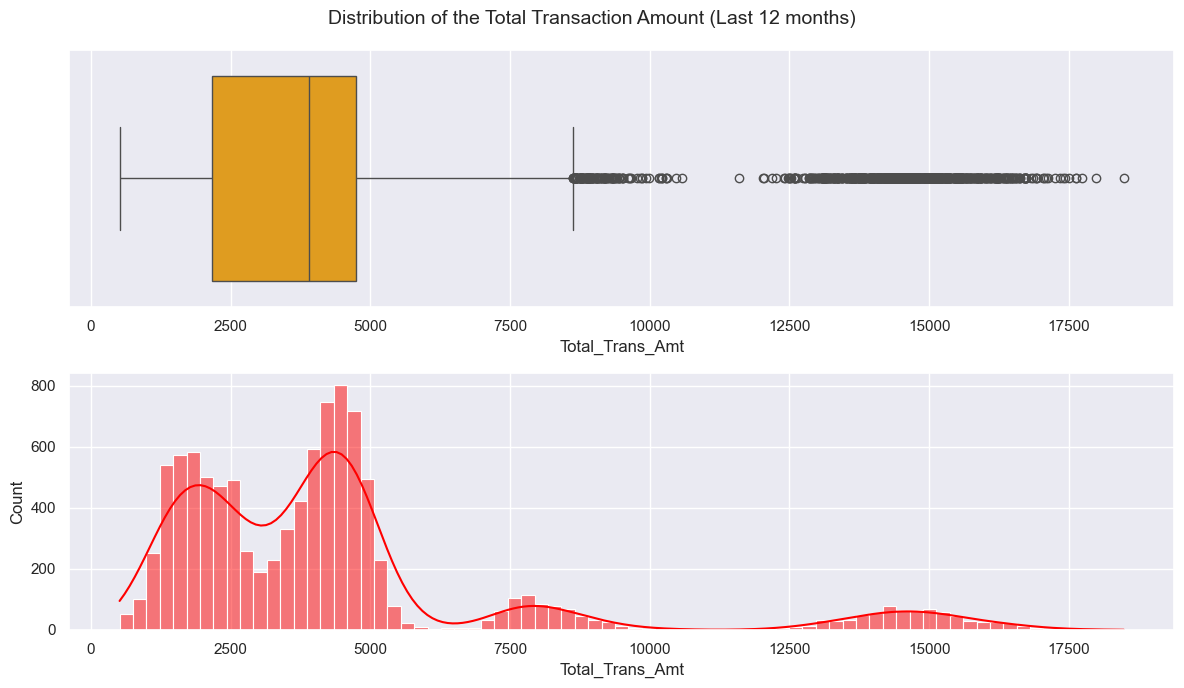

In [153]:
distPlot('Total_Trans_Amt', "Distribution of the Total Transaction Amount (Last 12 months)", bins=75)

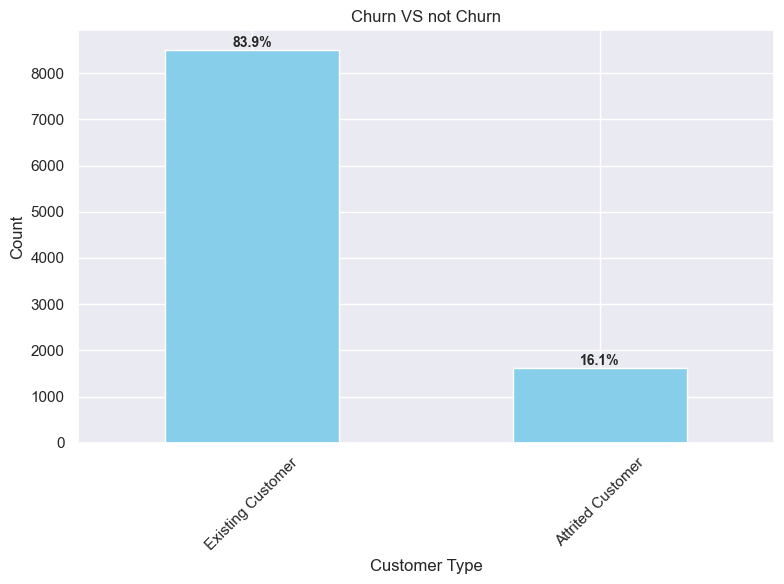

In [154]:
barPlot('Attrition_Flag', 'Churn VS not Churn', 'Customer Type', 'Count')

As we can see, only 16% of the data samples represent churn customers; in the following steps, I will use SMOTE to upsample the churn samples to match them with the regular customer sample size to give the later selected models a better chance of catching on small details which will almost definitely be missed out with such a size difference.

In [155]:
churnData

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [ ]:
churnData.Attrition_Flag = churnData.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
churnData.Gender = churnData.Gender.replace({'F':1,'M':0})
churnData = pd.concat([churnData,pd.get_dummies(churnData['Education_Level']).drop(columns=['Unknown'])],axis=1)
churnData = pd.concat([churnData,pd.get_dummies(churnData['Income_Category']).drop(columns=['Unknown'])],axis=1)
churnData = pd.concat([churnData,pd.get_dummies(churnData['Marital_Status']).drop(columns=['Unknown'])],axis=1)
churnData = pd.concat([churnData,pd.get_dummies(churnData['Card_Category']).drop(columns=['Platinum'])],axis=1)
churnData.drop(columns = ['Education_Level','Income_Category','Marital_Status','Card_Category','CLIENTNUM'],inplace=True)

Here we one hot encode all the categorical features describing different statuses of a customer.

In [157]:
oversample = SMOTE()
X, y = oversample.fit_resample(churnData[churnData.columns[1:]], churnData[churnData.columns[0]])
usampled_df = X.assign(Churn = y)

In [158]:
ohe_data =usampled_df[usampled_df.columns[15:-1]].copy()

usampled_df = usampled_df.drop(columns=usampled_df.columns[15:-1])

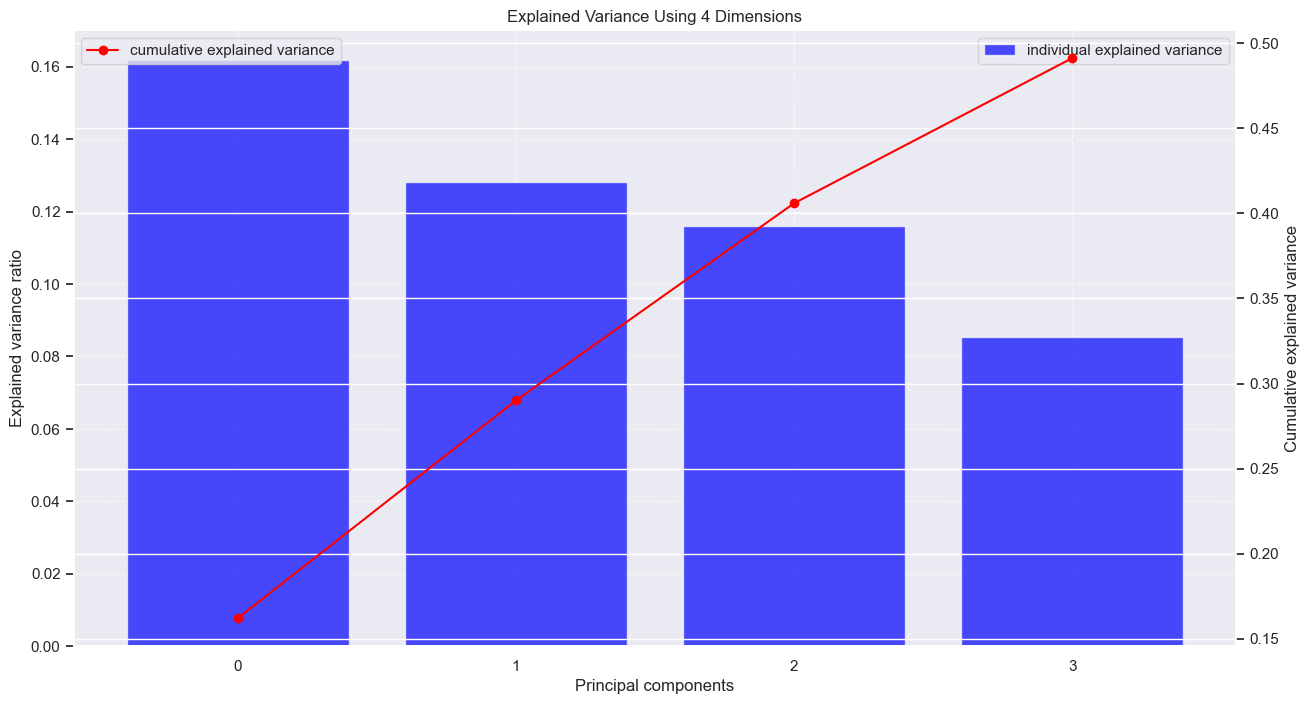

In [159]:
N_COMPONENTS = 4

pca_model = PCA(n_components = N_COMPONENTS )

pc_matrix = pca_model.fit_transform(ohe_data)

evr = pca_model.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

fig, ax1 = plt.subplots(figsize=(15, 8))

ax1.bar(range(N_COMPONENTS), evr, color='blue', alpha=0.7, label="individual explained variance")
ax1.set_xlabel("Principal components")
ax1.set_ylabel("Explained variance ratio")
ax1.set_title(f'Explained Variance Using {N_COMPONENTS} Dimensions')

ax2 = ax1.twinx()
ax2.plot(range(N_COMPONENTS), cumsum_evr, marker='o', color='red', linestyle='-', label="cumulative explained variance")
ax2.set_ylabel("Cumulative explained variance")

ax1.legend()
ax2.legend()

ax1.grid(True, linestyle="--", alpha=0.5)
plt.xticks(range(N_COMPONENTS))

plt.show()

In [160]:
usampledWithPCS = pd.concat([usampled_df,pd.DataFrame(pc_matrix,columns=['PC-{}'.format(i) for i in range(0,N_COMPONENTS)])],axis=1)

In [161]:
X_features = ['Total_Trans_Ct','PC-3','PC-1','PC-0','PC-2','Total_Ct_Chng_Q4_Q1','Total_Relationship_Count']

X = usampledWithPCS[X_features]
y = usampledWithPCS['Churn']

In [162]:
x_train,x_val,y_train,y_val = train_test_split(X,y,random_state=42)

In [163]:
xgb = XGB(random_state=42, tree_method="hist", device="gpu")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel="rbf", random_state=42)
lr = LR(random_state=42)
sc = StackingClassifier(estimators=[("xgb", xgb), ("rf", rf), ("svm", svm)], final_estimator=lr, passthrough=False)


rfPipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",rf) ])
xgbPipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",xgb) ])
svmPipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",svm) ])
linearPipe = Pipeline(steps =[ ('scale',StandardScaler()), ("RF",lr) ])
stackPipe = Pipeline([("scale", StandardScaler()), ("stack", sc)])

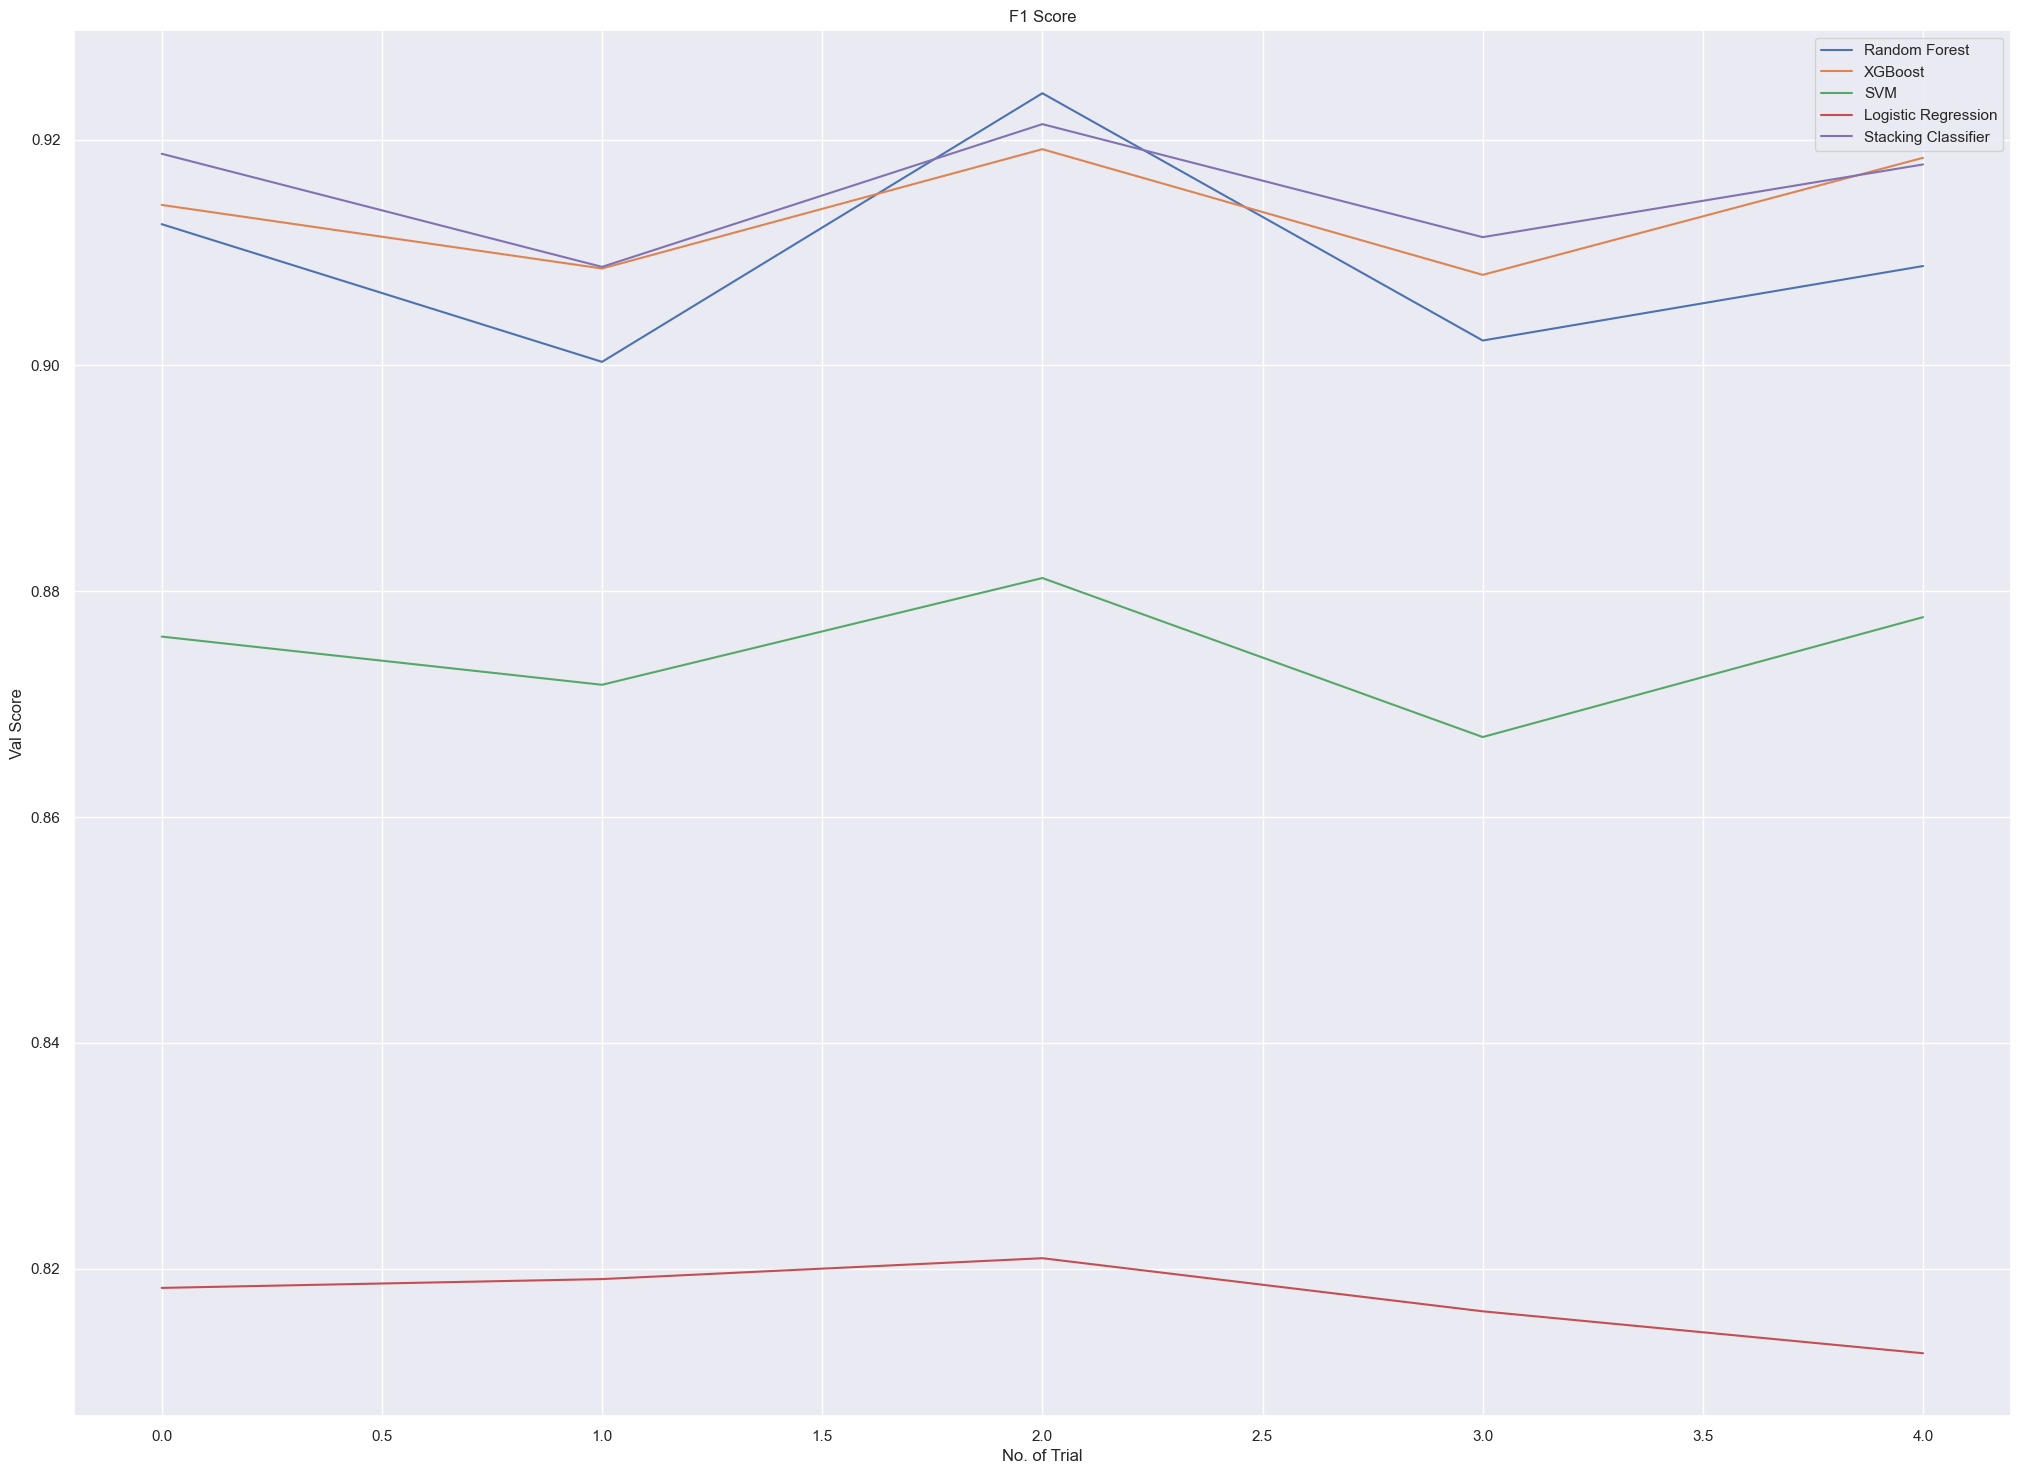

In [164]:
f1_cross_val_scores = cross_val_score(rfPipe,x_train,y_train,cv=5,scoring='f1')
xgb_f1_cross_val_scores=cross_val_score(xgbPipe,x_train,y_train,cv=5,scoring='f1')
svm_f1_cross_val_scores=cross_val_score(svmPipe,x_train,y_train,cv=5,scoring='f1')
lr_f1_cross_val_scores=cross_val_score(linearPipe, x_train,y_train,cv=5,scoring='f1')
sc_f1_cross_val_scores=cross_val_score(stackPipe, x_train,y_train,cv=5,scoring='f1')

plt.figure(figsize=(25,18))
plt.plot(f1_cross_val_scores)
plt.plot(xgb_f1_cross_val_scores)
plt.plot(svm_f1_cross_val_scores)
plt.plot(lr_f1_cross_val_scores)
plt.plot(sc_f1_cross_val_scores)
plt.title('F1 Score')
plt.xlabel('No. of Trial')
plt.ylabel('Val Score')
plt.legend(['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression', 'Stacking Classifier']);

In [165]:
rfPipe.fit(x_train,y_train)
rfPrediction = rfPipe.predict(x_val)

xgbPipe.fit(x_train,y_train)
xgbPrediction = xgbPipe.predict(x_val)

svmPipe.fit(x_train,y_train)
svmPrediction = svmPipe.predict(x_val)

linearPipe.fit(x_train, y_train)
linearPrediction = linearPipe.predict(x_val)

stackPipe.fit(x_train, y_train)
stackPrediction = stackPipe.predict(x_val)

In [166]:
print("With Upsampling:")
print(f"Random Forest: {np.round(f1_score(rfPrediction,y_val),2)}", f"XGBoost: {np.round(f1_score(xgbPrediction,y_val),2)}",f"SVM: {np.round(f1_score(svmPrediction,y_val),2)}", f"Logistic Regression: {np.round(f1_score(linearPrediction,y_val),2)}", f"Stacking Classifier: {np.round(f1_score(stackPrediction,y_val),2)}", sep='\n')

With Upsampling:
Random Forest: 0.91
XGBoost: 0.91
SVM: 0.88
Logistic Regression: 0.83
Stacking Classifier: 0.92


In [167]:
ohe_data =churnData[churnData.columns[16:]].copy()
pc_matrix = pca_model.fit_transform(ohe_data)
originalWithPCS = pd.concat([churnData,pd.DataFrame(pc_matrix,columns=['PC-{}'.format(i) for i in range(0,N_COMPONENTS)])],axis=1)

unsampledRF = rfPipe.predict(originalWithPCS[X_features])
unsampledXGB = xgbPipe.predict(originalWithPCS[X_features])
unsampledSVM = svmPipe.predict(originalWithPCS[X_features])
unsampledLR = linearPipe.predict(originalWithPCS[X_features])
unsampledSC = stackPipe.predict(originalWithPCS[X_features])

In [168]:
print("Without Upsampling:")
print(f"Random Forest: {np.round(f1_score(unsampledRF,originalWithPCS['Attrition_Flag']),2)}", f"XGBoost: {np.round(f1_score(unsampledXGB,originalWithPCS['Attrition_Flag']),2)}",f"SVM: {np.round(f1_score(unsampledSVM,originalWithPCS['Attrition_Flag']),2)}", f"Logistic Regression: {np.round(f1_score(unsampledLR,originalWithPCS['Attrition_Flag']),2)}", f"Stacking Classifier: {np.round(f1_score(unsampledSC,originalWithPCS['Attrition_Flag']),2)}", sep='\n')

Without Upsampling:
Random Forest: 0.44
XGBoost: 0.4
SVM: 0.52
Logistic Regression: 0.53
Stacking Classifier: 0.42


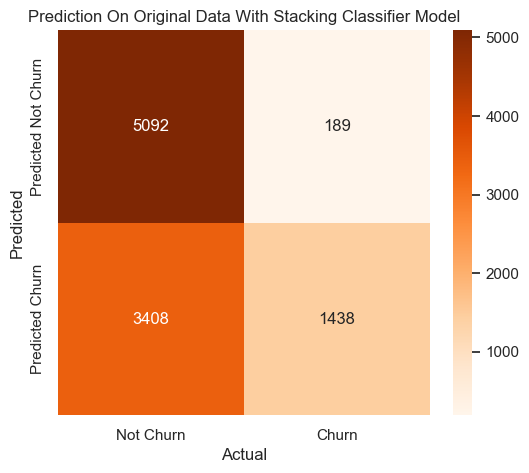

In [176]:
z=confusion_matrix(unsampledRF,originalWithPCS['Attrition_Flag'])

plt.figure(figsize=(6, 5))
ax = sns.heatmap(z, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not Churn','Churn'], yticklabels=['Predicted Not Churn','Predicted Churn'])
plt.title('Prediction On Original Data With Stacking Classifier Model')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()